![self-rag](https://i.imgur.com/X11ND6N.png)

In [101]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embeddings,
    collection_name='income_tax_coll',
    persist_directory='./income_tax_coll' 
)

retriever = vector_store.as_retriever(search_kwargs={'k': 5})

In [102]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [ ]:
def retrieve(state: AgentState) -> AgentState:

    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [104]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [105]:
from langchain import hub

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm  
    response = rag_chain.invoke({'question': query, 'context': context})
    return {'answer': response.content}

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [106]:
from langchain import hub
from langsmith import Client
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    
    query = state['query']  
    context = state['context']   
    print(f'context == {context}')
    doc_relevance_chain = doc_relevance_prompt | llm    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})  
    print(f'doc relevance responce: {response}')
    if response['Score'] == 1:  
        return 'relevant'
    
    return 'irrelevant'

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [107]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']   


rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전: {dictionary}
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState: 
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    
    return{'query': response}    

아래 출력을 보면 답변을 잘 나왔으나 할루시네이션으로 체킹된 것을 확인할 수 있음
할루시네이션 프롬프팅 셀 쪽 수정 필요

In [108]:
from langchain import hub

hallucination_prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def check_hallucination(state: AgentState):
    
    answer = state['answer']
    context = state['context']

    hallucination_chain = hallucination_prompt | llm
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
    print(f'hallucination response: {response}')

    if response['Score'] == 1:
        return 'generate'
    
    return 'end'

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


아래와 같이 수정

In [109]:
from langchain_core.prompts import PromptTemplate

hallucination_prompt = PromptTemplate.from_template("""
check whether the student's answer is hallucinated or not

documents: {documents}
student_answer: {student_answer}                                                   
""")

def check_hallucination(state: AgentState):
    
    answer = state['answer']
    context = state['context']

    hallucination_chain = hallucination_prompt | llm
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})
    print(f'hallucination response: {response}')

    if response['Score'] == 1:
        return 'generate'
    
    return 'end'

위 셀로 돌리면 아래에서 출력이 장황하게 나옴 
재수정

In [111]:
from langchain_core.prompts import PromptTemplate

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
check whether the student's answer is hallucinated or not
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated"
                                                    
documents: {documents}
student_answer: {student_answer}                                                   
""")


def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer,
                                            'documents': context})
    print(f'hallucination response: {response}')

    return response # 분기 과정에서 'Literal['hallucinated', 'not hallucinated']'에서 문자열을 요구하는데 객체 반환함 (→ .content or StroutParsor())

계속 할루시네이티드, , answer가 AI Message라서 그런가 .. 위 쪽 다시 수정해보자
generate prompt 셀 내 return {'answer': response} → return {'answer': response.content}
_ 
이래도 할루시네이티드. . context를 넣을 때를 수정해보자
List of Document이기 때문에 
이 때, string만 넣도록 수정 → 그래도 할루시네이티드
_
RAG 체인에서 답변의 수를 제한해보는 방식으로 수정, max_completion_tokens=100 → Not Hallucinated
+ 
_ 
다음으로는 https://smith.langchain.com/hub/langchain-ai/rag-answer-helpfulness 참고하여 helpfulness 노드 추가


In [112]:
from langchain import hub
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState):
    
    query = state['query']
    answer = state['answer']
    helpfulness_chain = helpfulness_prompt | llm
    response = helpfulness_chain.invoke({'student_answer': answer,
                                            'question': query})
    print(f'helpfulness response: {response}') 
    if response['Score'] == 1:
        return 'helpful'
    
    return 'unhelpful'

def check_helpfulness(state: AgentState):
    return state

/opt/anaconda3/envs/inflearn_langgraph/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [13]:
query = '연봉 5천만원인 거주자의 소득세는 얼마인가요?'
context = retriever.invoke(query)

generate_state = {'query': query, 'context': context}
answer = generate(generate_state)
print(f'answer == {answer}') 
hallucination_state = {'answer': answer, 'context': context}

check_hallucination(hallucination_state)

answer == {'answer': '연봉 5천만원인 거주자의 소득세는 과세표준 구간에 따라서 계산됩니다. 5천만원은 과세표준 1,400만원 초과 8,800만원 이하 구간에 해당하며, 이 경우 624만원의 기본세액에 5천만원을 초과하는 금액의 24%를 더해야 합니다. 계산 결과, 소득세는 624만원입니다.'}
hallucination response: content='not hallucinated' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 4292, 'total_tokens': 4295, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 4096}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'stop', 'logprobs': None} id='run-fee6f53c-ef7b-4650-a3fa-e77d8216a531-0' usage_metadata={'input_tokens': 4292, 'output_tokens': 3, 'total_tokens': 4295, 'input_token_details': {'audio': 0, 'cache_read': 4096}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


AIMessage(content='not hallucinated', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 4292, 'total_tokens': 4295, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 4096}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_deacdd5f6f', 'finish_reason': 'stop', 'logprobs': None}, id='run-fee6f53c-ef7b-4650-a3fa-e77d8216a531-0', usage_metadata={'input_tokens': 4292, 'output_tokens': 3, 'total_tokens': 4295, 'input_token_details': {'audio': 0, 'cache_read': 4096}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [25]:
query = '연봉 5천만원인 거주자의 소득세는 얼마인가요?'
context = retriever.invoke(query)

generate_state = {'query': query, 'context': context}
answer = generate(generate_state)

helpfulness_state = {'query': query, 'answer': answer}

check_helpfulness(helpfulness_state)

helpfulness response: {'Score': 1, 'Explanation': "The student's answer is concise and directly addresses the question. The student states the income tax for a resident with an annual salary of 50 million won is 6,240,000 won, which is the correct and relevant information needed to answer the question. The additional detail about the 24% tax rate on income exceeding 50 million won is relevant to explaining the calculation but isn't necessary for the answer. However, it does not detract from the answer's relevance."}


'helpful'

In [113]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('check_doc_relevance', check_doc_relevance)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_hallucination', check_hallucination)
graph_builder.add_node('check_helpfulness', check_helpfulness)


In [73]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve', 
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)
graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

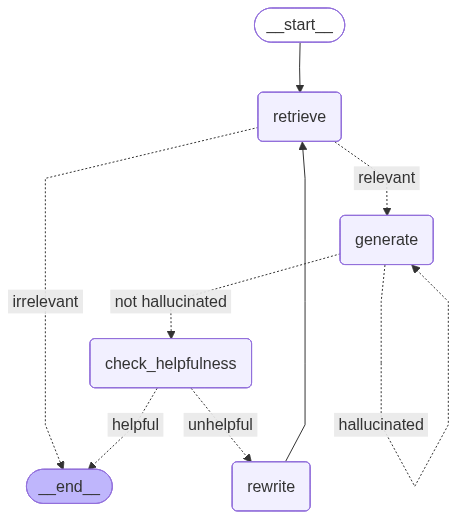

In [74]:
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

두 노드 삭제

In [114]:
graph_builder = StateGraph(AgentState)


In [115]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [116]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve', 
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)
graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

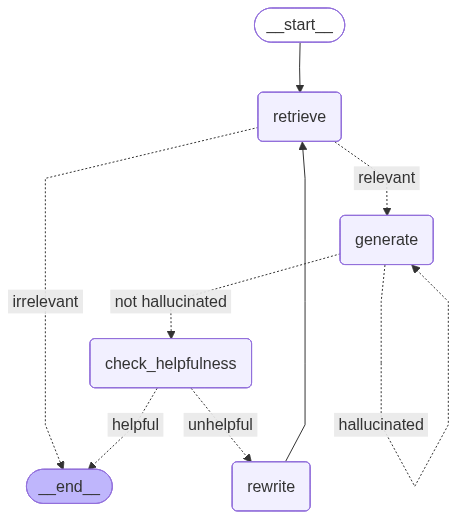

In [117]:
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [118]:
initial_state = {'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)

context == [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'), Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별

{'query': '연봉 5천만원인 사람이 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본